<a href="https://colab.research.google.com/github/Nungdoo/deep-learning-study/blob/main/exercise06_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SingleLayer 클래스를 상속하여 DualLayer 클래스 만들기

In [1]:
class SingleLayer:

  def __init__(self, learning_rate=0.1, l1=0, l2=0):
    self.w = None           # 가중치
    self.b = None           # 절편
    self.losses = []        # 훈련 손실
    self.val_losses = []    # 검증 손실
    self.w_history = []     # 가중치 기록
    self.lr = learning_rate # 학습률
    self.l1 = l1            # L1 손실
    self.l2 = l2            # L2 손실

  def forpass(self, x):
    z = np.dot(x, self.w) + self.b   ### 선형 출력을 계산합니다.
    return z

  def backprop(self, x, err):
    m = len(x)                        ### 샘플 개수를 저장합니다.
    w_grad = np.dot(x.T, err) / m     ### 가중치에 대한 평균 그레이디언트를 계산합니다.
    b_grad = np.sum(err) / m          ### 절편에 대한 평균 그레이디언트를 계산합니다.
    return w_grad, b_grad

  def activation(self, z):
    z = np.clip(z, -100, None)
    a = 1 / (1 + np.exp(-z))
    return a

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1, 1)                                  ### 타깃을 열 벡터로 바꿉니다.
    y_val = y_val.reshape(-1, 1)                          ### 검증용 타깃을 열 벡터로 바꿉니다.
    m = len(x)                                            ### 샘플 개수를 저장합니다.
    
    # 초기화
    self.w = np.ones((x.shape[1], 1))
    self.b = 0

    self.w_history.append(self.w.copy())
    for i in range(epochs):
      z = self.forpass(x)                                 # 정방향 계산을 수행합니다.
      a = self.activation(z)                              # 활성화 함수를 적용합니다.
      err = -(y - a)                                      # 오차를 계산합니다.
      
      # 오차를 역전파하여 그레이디언트를 계산합니다.
      w_grad, b_grad = self.backprop(x, err)
      ### 그레이디언트에서 페널티 항의 미분값을 더합니다.
      w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
      # 가중치와 절편을 업데이트합니다.
      self.w -= self.lr * w_grad
      self.b -= self.lr * b_grad
      # 가중치를 기록합니다.
      self.w_history.append(self.w.copy())
      # 안전한 로그 계산을 위해 클리핑합니다.
      a = np.clip(a, 1e-10, 1-1e-10)
      # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
      loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
      ### 에포크마다 평균 손실을 저장
      self.losses.append((loss + self.reg_loss()) / m)
      # 검증 세트에 대한 손실을 계산합니다.
      self.update_val_loss(x_val, y_val)

  def predict(self, x):
    z = self.forpass(x)
    return z > 0

  def score(self, x, y):
    ### 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
    return np.mean(self.predict(x) == y.reshape(-1, 1))

  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)    # 정방향 계산
    a = self.activation(z)        # 활성화 함수 적용
    a = np.clip(a, 1e-10, 1-1e-10)
    val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

  def reg_loss(self):
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class DualLayer(SingleLayer):
  def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):  # 은닉층의 뉴런 개수를 지정하는 units 매개변수 추가
    self.units = units      # 은닉층의 뉴런 개수
    self.w1 = None          # 은닉층의 가중치
    self.b1 = None          # 은닉층의 절편
    self.w2 = None          # 출력층의 가중치
    self.b2 = None          # 출력층의 절편
    self.a1 = None          # 은닉층의 활성화 출력, 역방향 계산 시 필요하여 저장
    self.losses = []        # 훈련 손실
    self.val_losses = []    # 검증 손실
    self.lr = learning_rate # 학습률
    self.l1 = l1            # L1 손실
    self.l2 = l2            # L2 손실

  def forpass(self, x):                       # 은닉층의 활성화 함수를 통과한 a1과 출력층의 가중치 w2를 곱하고 b2를 더하여 최종 출력 z2 반환
    z1 = np.dot(x, self.w1) + self.b1         # 첫 번째 층의 선형식 계산
    self.a1 = self.activation(z1)             # 활성화 함수 적용
    z2 = np.dot(self.a1, self.w2) + self.b2   # 두 번째 층의 선형식 계산
    return z2

  def backprop(self, x, err):
    m = len(x) # 샘플 개수

    # 출력층의 가중치와 절편에 대한 평균 그레이디언트 계산
    w2_grad = np.dot(self.a1.T, err) / m
    b2_grad = np.sum(err) / m

    # 시그모이드 함수까지 그레이디언트 계산 (편의를 위해 미리 계산해 둠)
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)

    # 은닉층의 가중치와 절편에 대한 평균 그레이디언트 계산
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis=0) / m

    return w1_grad, b1_grad, w2_grad, b2_grad

  def init_weights(self, n_features):
    self.w1 = np.ones((n_features, self.units))   # (특성 개수, 은닉층의 크기=뉴런의 개수)
    self.b1 = np.zeros(self.units)                # 은닉층의 크기
    self.w2 = np.ones((self.units, 1))            # (은닉층의 크기, 1)
    self.b2 = 0

  def training(self, x, y, m):
    z = self.forpass(x)                                 # 정방향 계산을 수행합니다.
    a = self.activation(z)                              # 활성화 함수를 적용합니다.
    err = -(y - a)                                      # 오차를 계산합니다.
    
    # 오차를 역전파하여 그레이디언트를 계산합니다.
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)

    # 그레이디언트에서 페널티 항의 미분값을 더합니다.
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m

    # 은닉층의 가중치와 절편을 업데이트합니다.
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad

    # 출력층의 가중치와 절편을 업데이트합니다.
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad

    # 출력층의 활성화 출력 a를 반환합니다.
    return a

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1, 1)                                  # 타깃을 열 벡터로 바꿉니다.
    y_val = y_val.reshape(-1, 1)                          # 검증용 타깃을 열 벡터로 바꿉니다.
    m = len(x)                                            # 샘플 개수를 저장합니다.
    
    # 은닉층과 출력층의 가중치 초기화
    self.init_weights(x.shape[1])

    for i in range(epochs):
      a = self.training(x, y, m)

      a = np.clip(a, 1e-10, 1-1e-10)                      # 안전한 로그 계산을 위해 클리핑합니다.
      loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))   # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
      self.losses.append((loss + self.reg_loss()) / m)    # 에포크마다 평균 손실을 저장
      self.update_val_loss(x_val, y_val)                  # 검증 세트에 대한 손실을 계산합니다.

  def reg_loss(self):
    # 은닉층과 출력층의 가중치에 대한 L1, L2 손실 계산
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

모델 훈련하기

In [5]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

dual_layer = DualLayer(l2=0.01)
dual_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=20000)
dual_layer.score(x_val_scaled, y_val)

0.978021978021978

문제가 간단하여 SingleLayer와 평가 점수 동일

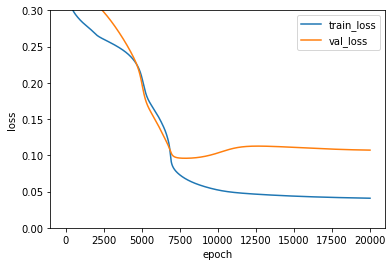

In [6]:
plt.ylim(0, 0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

SIngleLayer보다 가중치의 개수가 많아져 학습하는데 오래걸려 더 느리게 손실이 감소함

In [7]:
class RandomInitNetwork(DualLayer):
  def init_weights(self, n_features):
    np.random.seed(42)
    self.w1 = np.random.normal(0, 1, (n_features, self.units))   # (특성 개수, 은닉층의 크기=뉴런의 개수)
    self.b1 = np.zeros(self.units)                               # 은닉층의 크기
    self.w2 = np.random.normal(0, 1, (self.units, 1))            # (은닉층의 크기, 1)
    self.b2 = 0

개선해보자!
- 초기 손실값이 감소하는 곡선이 매끄럽지 않음, 가중치 초기화와 관련 깊음
- 정규분포를 따르는 무작위 수로 가중치 초기화하자
- np.random.normal(평균, 표준 편차, 배열 크기)

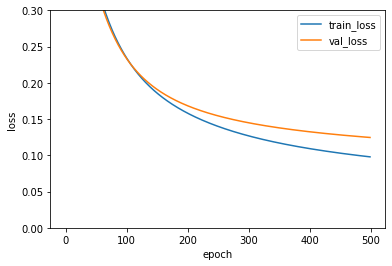

In [8]:
random_init_net = RandomInitNetwork(l2=0.01)
random_init_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)

plt.ylim(0, 0.3)
plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

- 손실 함수가 감소하는 곡선이 매끄러워짐
- 훨씬 빠르게 손실 함수 값이 감소함